<a href="https://colab.research.google.com/github/andyherzberg/pytorch-transfer-learning-classifier/blob/master/Transfer_Learning_on_bee_like_insects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Mount Google Drive</h1> </br>
<a href=https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228>https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228</a> 

In [0]:
import os 
from google.colab import drive # import drive library from colab

drive.mount("/content/drive/") # mount drive at /content/drive
os.chdir("/content/drive/My Drive/AI_UDACITY_COLAB/_transfer learning on insects") # change folder in gdrive
os.getcwd()  # print current working dir and save to PATH
os.listdir()  # list files, folders

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['insects',
 'data',
 'Copy of Transfer Learning on bee like insects.ipynb',
 'Transfer Learning on bee like insects.ipynb']

<h1> Create data loader</h1>

In [0]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np

# set mean and std for the model according to specs
# https://pytorch.org/docs/stable/torchvision/models.html?highlight=torchvision%20models 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# create transforms
train_transforms = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(20),
                                transforms.RandomResizedCrop(224, scale = (0.4,1.)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)
])


vali_transforms = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)
])

test_transforms = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)
])

# create datasets without transform
dataset = datasets.ImageFolder("./insects", transform=None)

# create datasets with different transforms
train_dataset = datasets.ImageFolder("./insects", transform=train_transforms)
vali_dataset = datasets.ImageFolder("./insects", transform=vali_transforms)
test_dataset = datasets.ImageFolder("./insects", transform=test_transforms)

In [0]:
# create indices and shuffle them
len_dataset = len(dataset)
indices = list(range(len_dataset))
np.random.shuffle(indices)

In [0]:
# set distribution of train, test, vali
train_split, vali_split, test_split = 0.7, 0.2, 0.1

# create indices lists 
train_indices = indices[0:int(train_split * len_dataset)]
vali_indices = indices[int(train_split * len_dataset) : (int(train_split * len_dataset) + int(vali_split * len_dataset))]
test_indices = indices[(int(train_split * len_dataset) + int(vali_split * len_dataset)): len_dataset]

In [0]:
# check whether index lists have the same length as the dataset
len(train_indices)+len(vali_indices)+len(test_indices) == len(dataset)
print(len(train_indices), len(vali_indices), len(test_indices))

175 50 26


In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

# create sampler for the data loader
train_sampler = SubsetRandomSampler(train_indices)
vali_sampler = SubsetRandomSampler(vali_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [0]:
batch_size = 10

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
vali_loader = torch.utils.data.DataLoader(vali_dataset, batch_size=batch_size, sampler=vali_sampler, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, drop_last=True)

In [0]:
iter_loader = iter(train_loader)
images, labels = next(iter_loader)
# print(images)

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# un-normalize and display an image
def imshow(img, label):
    # unnormalize as sggested here: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/8     
    inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
    )
    
    #img = img.type(torch.ByteTensor)
    img = inv_normalize(img)

    # change tensor structure to match matplotlib.pyplot specs
    # torch.Size([224, 224, 3]) instead of torch.Size([3, 224, 224]
    img=img.permute(1,2,0) 

    # https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.imshow.html
    plt.imshow(img, vmin=0, vmax=255);  # convert from Tensor image

    # Map ids to class names
    if label.item() == 0:
      plt.title("bee");
    elif label.item() == 1:
      plt.title("humble bee");
    if label.item() == 2:
      plt.title("wasp");

# fig = imshow(images[4], labels[4])   # debug

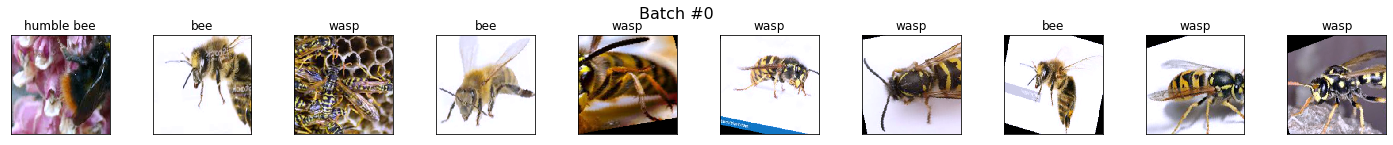

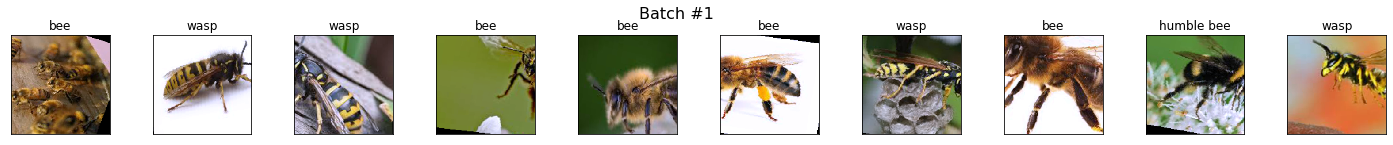

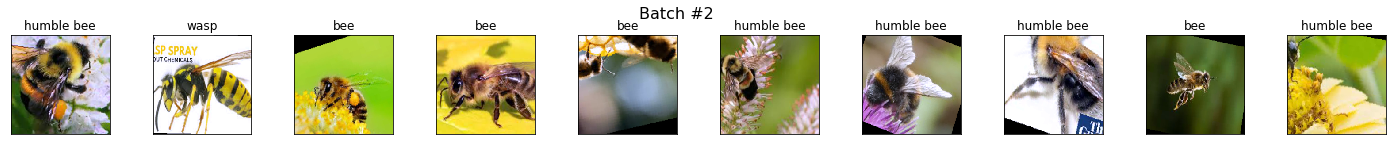

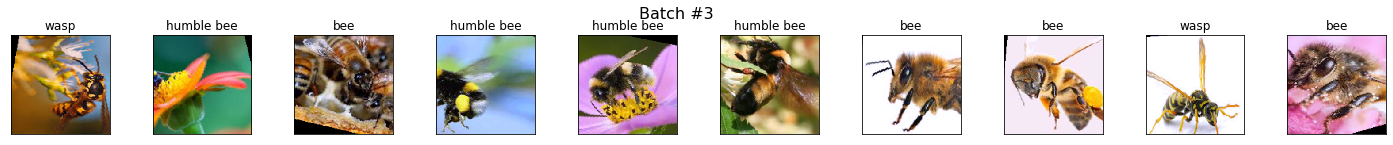

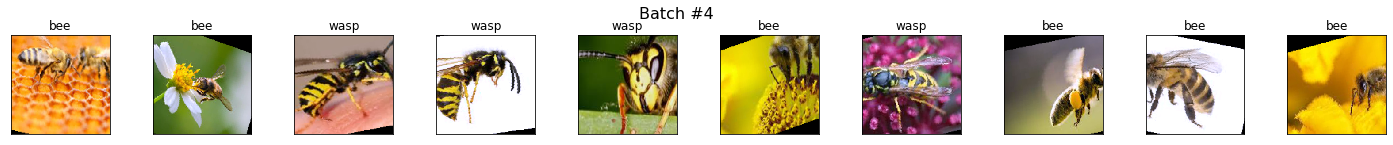

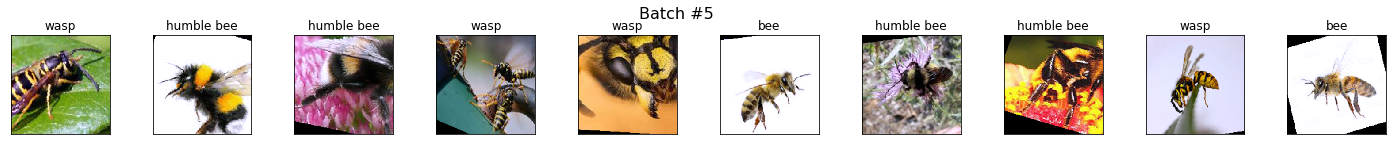

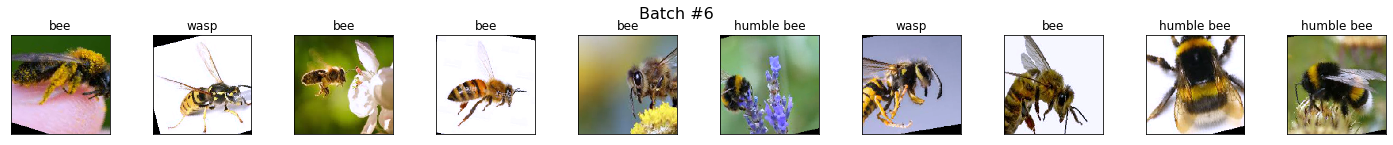

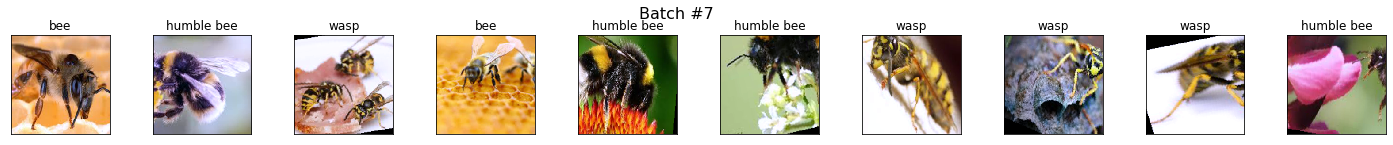

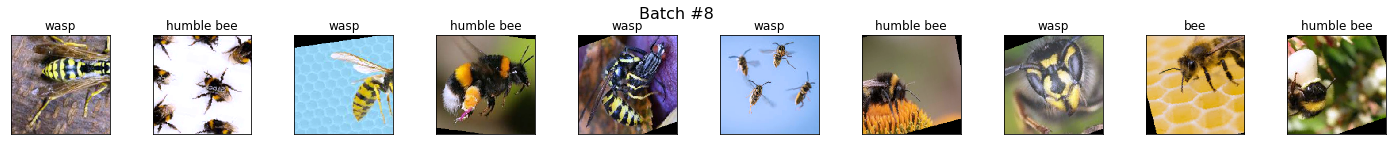

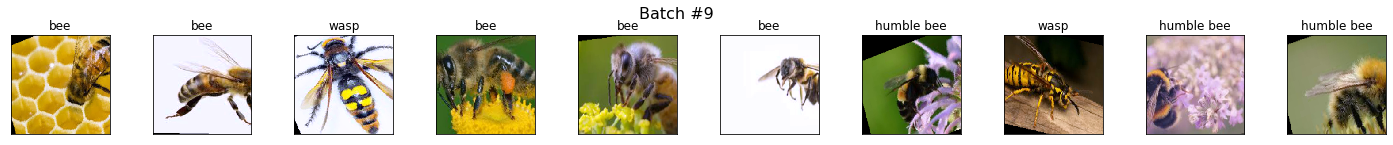

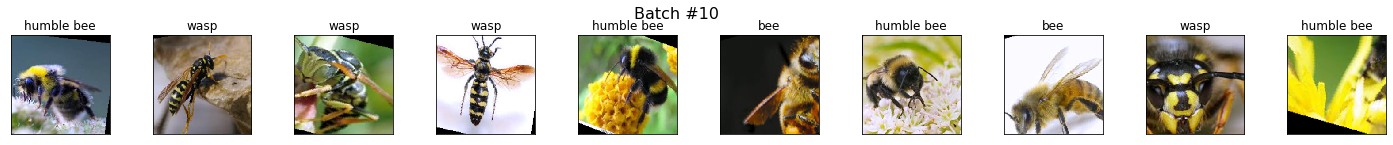

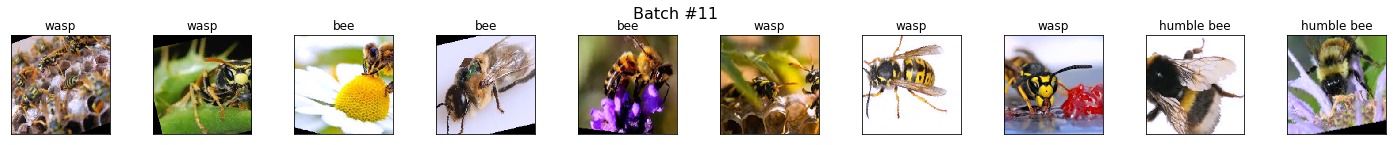

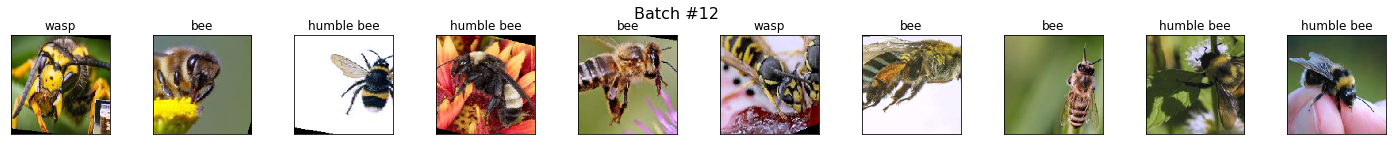

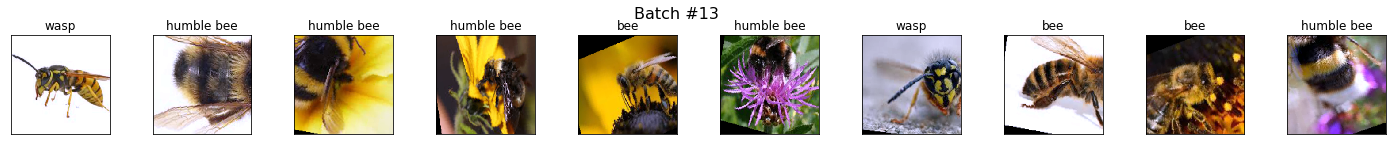

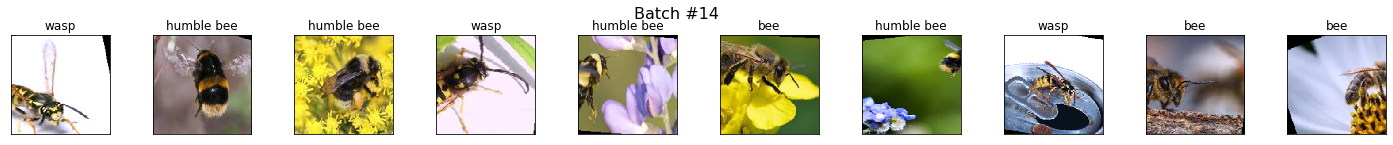

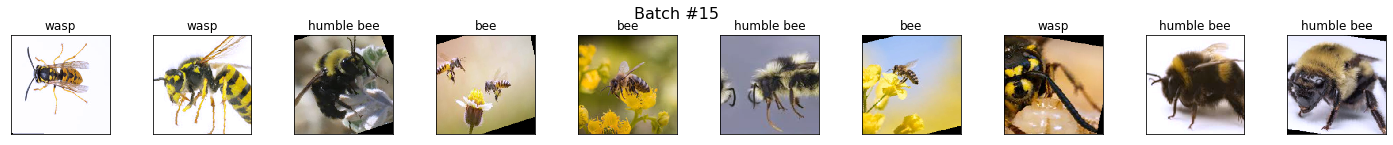

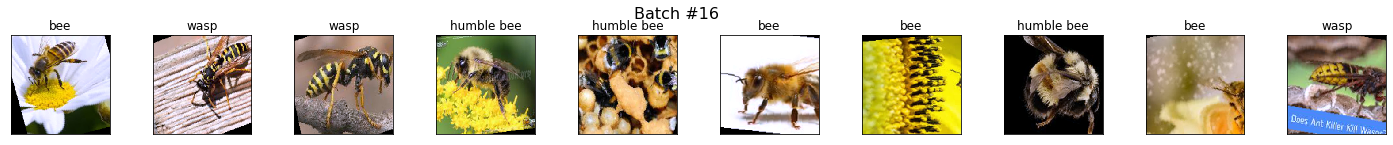

In [0]:
# Ignore annoying "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)." message. 
import logging
logger = logging.getLogger()
logger.setLevel(100)

for i, data in enumerate(train_loader):
  batch_n = len(data[0])
  images, labels = data[0], data [1]

  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  # display 20 images
  for idx in np.arange(batch_n):
      fig.suptitle('Batch #'+str(i), fontsize=16)
      ax = fig.add_subplot(2, batch_n, idx+1, xticks=[], yticks=[])
      imshow(images[idx], labels[idx])



<h1>Load existing model</h1><br>
<a href=https://pytorch.org/docs/stable/torchvision/models.html?highlight=torchvision%20models> https://pytorch.org/docs/stable/torchvision/models.html?highlight=torchvision%20models</a>

In [0]:
from torchvision import models 

# download pretrained model 
model = models.resnet50(pretrained=True)

In [0]:
# print(model)

In [0]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [0]:
# only freeze layers that aren't BatchNorm
for name, param in model.named_parameters():
  if ('bn' not in name):
    param.requires_grad = False

<h1>Replace classifier in existing model</h1>

In [0]:
from torch import nn

model.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    nn.Linear(1000, 256),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    nn.Linear(256, 3), #, 3    
    nn.LogSoftmax(dim=1))

In [0]:
# print(model)

In [0]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),
                      lr=0.003) 

<h1>Train model and validate on vali dataset</h1>

In [0]:
import time

def train(epochs):

  epochs = epochs
  steps = 0
  train_losses, vali_losses = [], []
  running_loss = 0
  print_every = 5

  log = []

  for epoch in range(epochs):
      for inputs, labels in train_loader:
          steps += 1

          optimizer.zero_grad()
          
          logps = model.forward(inputs)
          loss = criterion(logps, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          
          if steps % print_every == 0:
            vali_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in vali_loader:
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    vali_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(train_loader))
            vali_losses.append(vali_loss/len(vali_loader))   
            timestamp = time.strftime("%Y-%m-%dT%H:%M:%S")   
            print(f"Time: {timestamp}.. "
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/len(train_loader):.3f}.. "
                  f"Vali loss: {vali_loss/len(vali_loader):.3f}.. "
                  f"Vali accuracy: {accuracy/len(vali_loader):.3f}")
            
            log.append([timestamp, epoch+1, round(running_loss/len(train_loader), 3), round(vali_loss/len(vali_loader), 3), round(accuracy/len(vali_loader), 3)])

            # save model and optimizer state_dict() in each interation
            torch.save(model, "./state_dicts/" + timestamp + '_model_epoch#' + str(epoch+1) + '.pth')  #.state_dict()
            torch.save(optimizer.state_dict(), "./state_dicts/" +  timestamp + '_optimizer_state_dict_epoch#' + str(epoch+1) + '.pth')

            running_loss = 0
            model.train()

  return log, train_losses, vali_losses


In [20]:
import pandas as pd  
import pickle
import warnings

# suppress warnings when loading model
warnings.filterwarnings('ignore') 

# call train function with number of epochs
log, train_losses, vali_losses = train(50)

# create logfile and store in root dir
log_df = pd.DataFrame(log, columns=['Time', 'Epoch', 'Train loss', 'Vali loss', 'Vali Accuracy'])
log_name = time.strftime("%Y-%m-%dT%H:%M:%S") + '_log.csv'
log_df.to_csv(log_name, index=False, columns=['Time', 'Epoch', 'Train loss', 'Vali loss', 'Vali Accuracy'])

# save into a pickle file
pickle_name = time.strftime("%Y-%m-%dT%H:%M:%S") + "_save.pk"
pickle.dump( [train_losses, vali_losses, train_dataset, vali_dataset, test_dataset, log], open(pickle_name , "wb" ) )

Time: 2020-01-22T06:04:24.. Epoch 1/50.. Train loss: 0.623.. Vali loss: 1.202.. Vali accuracy: 0.560
Time: 2020-01-22T06:04:57.. Epoch 1/50.. Train loss: 0.318.. Vali loss: 0.646.. Vali accuracy: 0.960
Time: 2020-01-22T06:05:30.. Epoch 1/50.. Train loss: 0.231.. Vali loss: 0.539.. Vali accuracy: 0.720
Time: 2020-01-22T06:06:04.. Epoch 2/50.. Train loss: 0.146.. Vali loss: 0.202.. Vali accuracy: 0.940
Time: 2020-01-22T06:06:37.. Epoch 2/50.. Train loss: 0.129.. Vali loss: 0.572.. Vali accuracy: 0.760
Time: 2020-01-22T06:07:10.. Epoch 2/50.. Train loss: 0.117.. Vali loss: 0.383.. Vali accuracy: 0.820
Time: 2020-01-22T06:07:44.. Epoch 3/50.. Train loss: 0.098.. Vali loss: 0.171.. Vali accuracy: 0.920
Time: 2020-01-22T06:08:17.. Epoch 3/50.. Train loss: 0.089.. Vali loss: 0.185.. Vali accuracy: 0.980
Time: 2020-01-22T06:08:50.. Epoch 3/50.. Train loss: 0.105.. Vali loss: 0.178.. Vali accuracy: 0.940
Time: 2020-01-22T06:09:22.. Epoch 3/50.. Train loss: 0.130.. Vali loss: 0.112.. Vali accura

<h1>Mount Google Drive</h1>

In [21]:
import os 
from google.colab import drive # import drive library from colab

drive.mount("/content/drive/") # mount drive at /content/drive
os.chdir("/content/drive/My Drive/AI_UDACITY_COLAB/_transfer learning on insects") # change folder in gdrive
os.getcwd()  # print current working dir and save to PATH
os.listdir()  # list files, folders

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['insects',
 'data',
 'Transfer Learning on bee like insects.ipynb',
 'state_dicts',
 'Copy of Transfer Learning on bee like insects.ipynb',
 '2020-01-22T07:38:26_log.csv',
 '2020-01-22T07:38:26_save.pk']

<h1>Load pickle</h1>
Mount gdrive first!

In [0]:
import pickle

# load the pickle file
train_losses, vali_losses, train_dataset, vali_dataset, test_dataset, log = pickle.load( open( "2020-01-22T07:38:26_save.pk", "rb" ) )

<h1>Plot training and validation loss</h1>

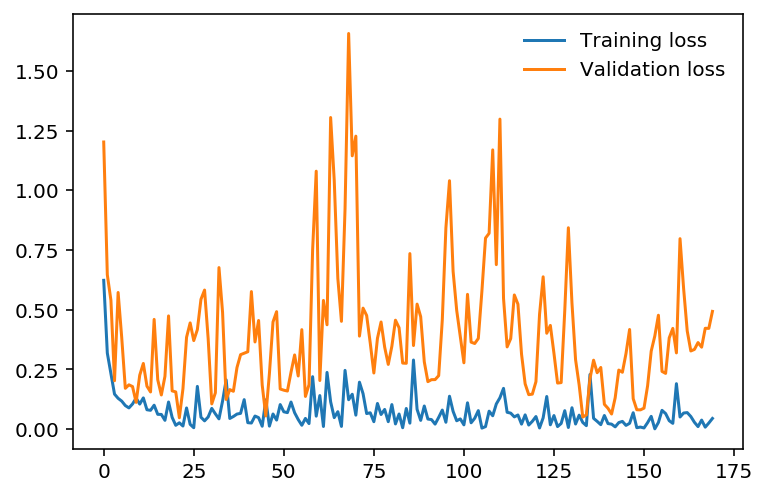

In [24]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training loss")
plt.plot(vali_losses, label="Validation loss")
plt.legend(frameon=False);

<h1>Load model and optimizer state_dict()</h1>

In [0]:
# set path to best model state_dict()
path_model = './state_dicts/2020-01-22T06:15:50_model_epoch#7.pth'
path_optimizer_state_dict = './state_dicts/2020-01-22T06:15:50_optimizer_state_dict_epoch#7.pth'

In [30]:
import torch
from torch import optim

# load model 
model = torch.load(path_model)

# set optimizer
optimizer = optim.Adam(model.parameters(),
                      lr=0.01)  
# load optimizer state dict
optimizer.load_state_dict(torch.load(path_optimizer_state_dict))

# set to evaluation
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<h1>Predict on previously unseen test dataset</h1>

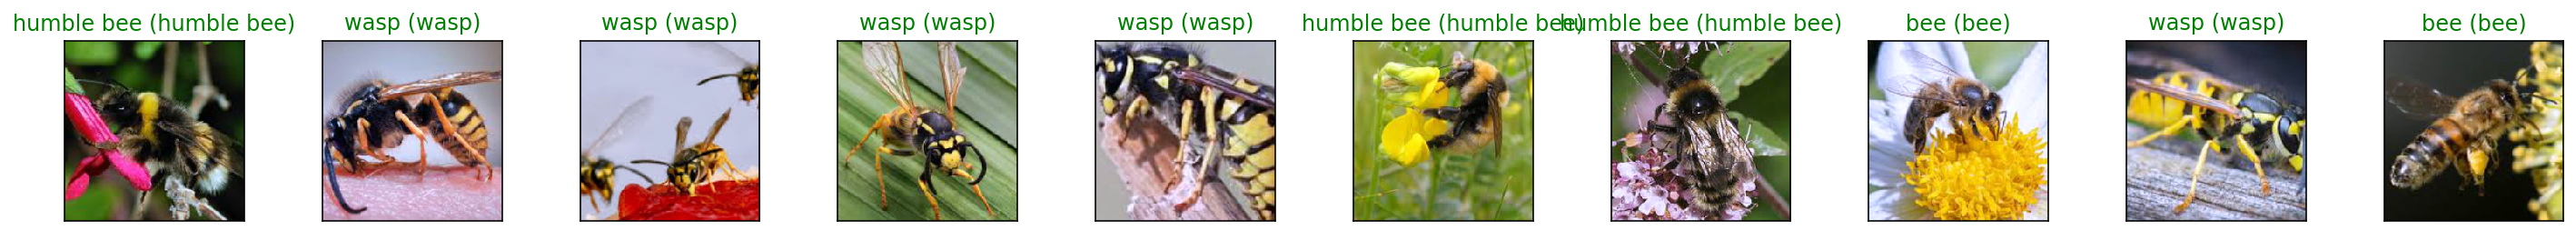

In [31]:
# Ignore annoying "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)." message. 
import logging
logger = logging.getLogger()
logger.setLevel(100)

# obtain one batch of test images
dataiter = iter(vali_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))   # width, height in inches. 
for idx in np.arange(20): 
  for idx in np.arange(batch_n):
      ax = fig.add_subplot(2, batch_n, idx+1, xticks=[], yticks=[])
      imshow(images[idx], labels[idx])

      # map ids to class names
      if labels[idx].item() == 0:
        real_label= "bee"
      elif labels[idx].item() == 1:
        real_label= "humble bee"
      if labels[idx].item() == 2:
        real_label= "wasp"

       # map ids to class names
      if preds[idx].item() == 0:
        preds_label= "bee"
      elif preds[idx].item() == 1:
        preds_label= "humble bee"
      if preds[idx].item() == 2:
        preds_label= "wasp"     

      ax.set_title("{} ({})".format(preds_label, real_label),
                  color=("green" if preds[idx]==labels[idx] else "red"))

<h1>Visualize convolutional filters</h1>

<Figure size 432x288 with 0 Axes>

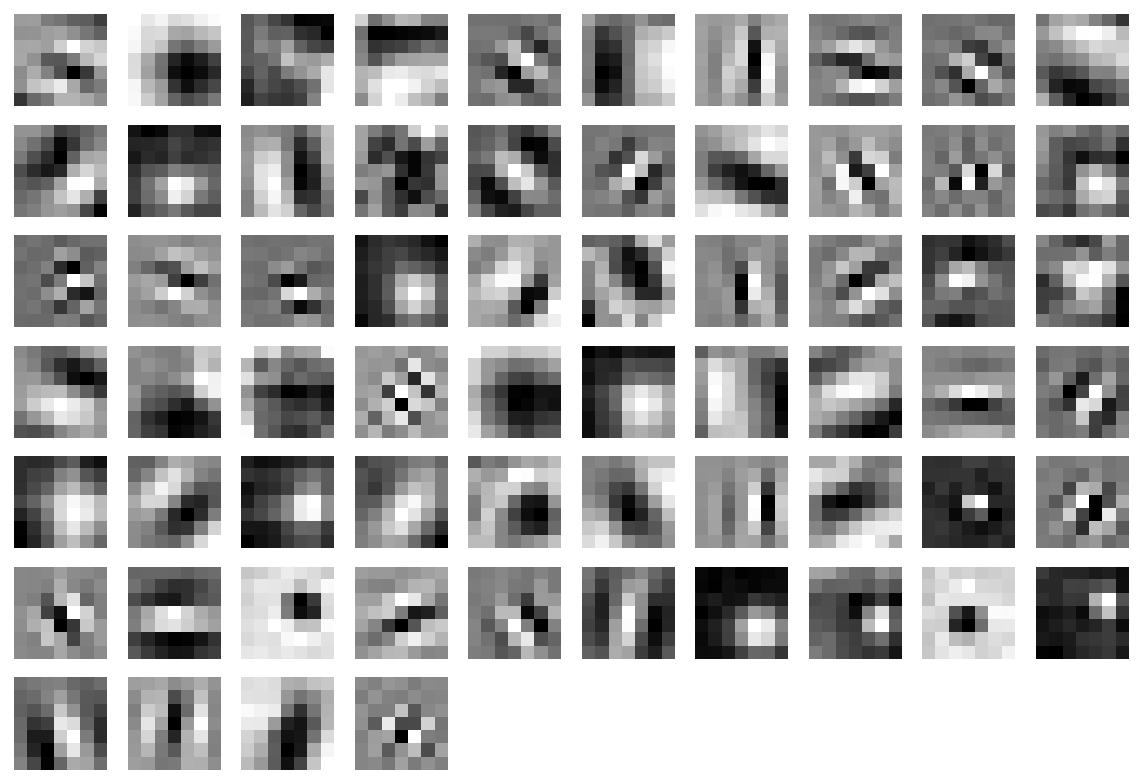

In [35]:
fig = plt.figure()
plt.figure(figsize=(10,10))
for idx, filt  in enumerate(model.conv1.weight.data):
  plt.subplot(10,10, idx + 1)
  plt.imshow(filt[0, :, :], cmap="gray")
  plt.axis('off')
  fig.show()

<br>
<br>
<br>
<br>
<br>
<br>

<h1>Loading cifar model in order to check the neural network</h1>

In [0]:
debug = False

if debug == True:

  from torchvision import datasets
  import torchvision.transforms as transforms
  from torch.utils.data.sampler import SubsetRandomSampler

  # number of subprocesses to use for data loading
  num_workers = 0
  # how many samples per batch to load
  batch_size = 20
  # percentage of training set to use as validation
  vali_size = 0.2

  # convert data to a normalized torch.FloatTensor
  transform = transforms.Compose([
      transforms.Resize(255),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

  # choose the training and test datasets
  train_data = datasets.CIFAR10('data', train=True,
                                download=True, transform=transform)
  test_data = datasets.CIFAR10('data', train=False,
                              download=True, transform=transform)

  # obtain training indices that will be used for validation
  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(vali_size * num_train))
  train_idx, vali_idx = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_idx)
  vali_sampler = SubsetRandomSampler(vali_idx)

  # prepare data loaders (combine dataset and sampler)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
      sampler=train_sampler, num_workers=num_workers)
  vali_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
      sampler=vali_sampler, num_workers=num_workers)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
      num_workers=num_workers)

  # specify the image classes
  classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck']

<h1>Display a batch of cifar train data</h1>

In [0]:
if debug == True:

  iter_loader = iter(train_loader)
  images, labels = next(iter_loader)
  # print(images)

In [0]:
if debug == True:

  import warnings
  warnings.simplefilter('ignore')

  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  # display 20 images
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      imshow(images[idx], labels[idx])